In [50]:
from IPython.core.display import HTML, display
import pickle
from warnings import filterwarnings

import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from seaborn import heatmap
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
from cmocean import cm as cmo

from pymc_utils import PyMCModel
from pymc_utils import Ordered
from pymc_utils import subset_significant_feature

In [3]:
filterwarnings('ignore', category=UserWarning)

In [4]:
display(HTML("<style>.container {width: 90% !important}</style>"))

In [5]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [6]:
def bayes_nn_model_l1_h(X, y_obs, n_hidden=None, lklhd_name='likelihood'):
    """
    Hierarchical Bayesian NN Implementation with ARD.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    
    testvals = np.sort(np.random.randn(n_hidden))
    with pm.Model() as model:
        hyp_wi1_sd = pm.HalfCauchy('hyp_w_i_1_sd', beta=1, shape=(num_feats,1))
        hyp_w1o_sd = pm.HalfCauchy('hyp_w_1_out_sd', beta=1)
        hyp_bias_1_sd = pm.HalfCauchy('hyp_bias_1_sd', beta=1)
        hyp_bias_o_sd = pm.HalfCauchy('hyp_bias_o_sd', beta=1)
         
        w_i_1_step = pm.Normal('w_i_1_s', mu=0, sd=1, shape=(num_feats, n_hidden))
        w_i_1 = pm.Deterministic('wts_i_1', w_i_1_step * hyp_wi1_sd, )
        w_1_o_step = pm.Normal('w_1_o_s', mu=0, sd=1, shape=n_hidden)
        w_1_o = pm.Deterministic('wts_1_o', w_1_o_step * hyp_w1o_sd, )
        #b_1_step = pm.Normal('b_1_s', mu=0, sd=1, shape=n_hidden)
        b_1 = pm.Normal('bias_1', mu=0, sd=hyp_bias_1_sd, shape=n_hidden,
                        transform=Ordered(), testval=testvals)
        b_o = pm.Normal('bias_o', mu=0, sd=hyp_bias_o_sd)
        lyr1_act = pm.Deterministic('layer1_act', pm.math.theano.tensor.nnet.elu(tt.dot(X, w_i_1) + b_1) )
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b_o )
        
        sd = pm.HalfCauchy('sd', beta=5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [65]:
def plot_pairwise_corr(df_, ax=None, **heatmap_kwgs):
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 10))
    heatmap(df_.corr().iloc[1:,:-1],vmin=-1, vmax=1,
            mask=np.triu(np.ones([df_.shape[1]-1] * 2),k=1),
            ax=ax, **heatmap_kwgs,
            #annot=True, annot_kws={'fontsize': 10}, cmap=cmo.balance_r
           )
    ax.set_facecolor('k')
    return ax

def plot_fits_w_estimates(y_obs, ppc, ax=None, savename=False):
    """ Plot Fits with Uncertainty Estimates"""
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean =ppc.mean(axis=0)
    lik_hpd = pm.hpd(ppc)
    lik_hpd_05 = pm.hpd(ppc, alpha=0.5)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
    ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=100,
               color='steelblue', marker='d', zorder=2);
    ax.scatter(ix, lik_mean[iy], label='model mean', edgecolor='k', marker='^',
               s=100, color='orange', zorder=3)

    ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], color='gray', 
                   label='model output 50%CI', zorder=1,linestyle='-', lw=2, edgecolor='k');
    ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], color='k', alpha=0.75,
                   label='model output 95%CI', zorder=0, );
    ax.legend(loc='upper left');
    if savename:
        f = pl.gcf()
        f.savefig('./figJar/bayesNet/bNN_L1_nobias.pdf', format='pdf')
    return ax

def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    mae = mean_absolute_error(y_obs, ppc_mean)
    r2 = r2_score(y_obs, ppc_mean)
    
    scatter_lbl = f'$r^2$={r2:.2f}, mae={mae:.2f}'
    scatter_lbl = scatter_kwds.pop('label', scatter_lbl)
    ax.scatter(y_obs, ppc_mean, edgecolor='k', label=scatter_lbl, **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')
    ax.legend(loc='upper left')
    return ax

def uncertainty_plot_2(ppc_train, ppc_test, y_test_, y_train_, ax, band_color,
                      scatter_zorder=2, hpd_zorder=0, hpd_50_zorder=1):
    ix_ = np.argsort(y_train_)
    hpd_50 = pm.hpd(ppc_train[:, ix_], alpha=0.5)
    hpd = pm.hpd(ppc_train[:, ix_],)
    mean_ = ppc_train[:, ix_].mean(axis=0)
    mean_test_ = ppc_test.mean(axis=0)
    ax.scatter(mean_test_, y_test_, edgecolor='k', lw=2, zorder=scatter_zorder, color=band_color, s=50)
    ax.fill_betweenx(mean_, x1=hpd[:, 0], x2=hpd[:, 1], alpha=0.25, zorder=hpd_zorder, color=band_color)
    ax.fill_betweenx(mean_, x1=hpd_50[:, 0], x2=hpd_50[:, 1], alpha=0.25, color=band_color)

In [12]:
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_FullSet_noInteractions.pkl')
#ds['log10_aphy%d' % band] = np.log10(ds.loc[:, 'aphy%d' % band])
#ds.to_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')

In [13]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
BiomCat,494.0,1.536437e+00,1.375565,0.000000,0.000000,2.000000,3.000000,3.000000
Coastal,494.0,4.170040e-01,0.493563,0.000000,0.000000,0.000000,1.000000,1.000000
ProvCat,494.0,2.888259e+01,16.174203,2.000000,17.000000,29.000000,46.000000,50.000000
sin_doy,494.0,-1.561073e-02,0.740762,-0.999991,-0.835925,-0.060213,0.717677,0.999917
cos_doy,494.0,-1.240505e-01,0.661540,-0.999963,-0.774863,-0.183998,0.482508,0.999852
sin_minofday,494.0,-7.536568e-01,0.384585,-1.000000,-0.984808,-0.867112,-0.716302,1.000000
cos_minofday,494.0,-1.766368e-01,0.503694,-0.999962,-0.546464,-0.152123,0.172574,0.992005
x,494.0,1.486906e-01,0.332515,-0.989566,0.101136,0.190511,0.278906,0.992996
y,494.0,-6.684908e-01,0.318289,-0.895108,-0.879685,-0.717153,-0.667773,0.914999
z,494.0,4.691095e-01,0.315759,-0.924832,0.453005,0.535974,0.673687,0.981627


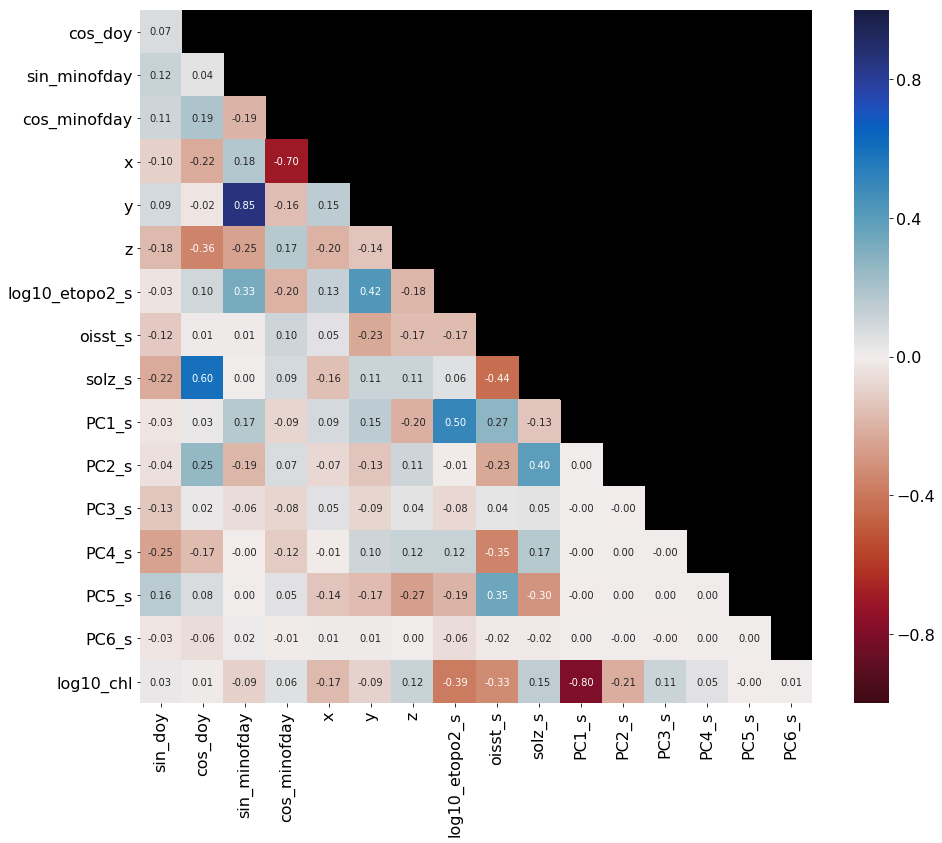

In [14]:
f, ax = pl.subplots(figsize=(14, 12))
plot_pairwise_corr(ds.loc[:, 'sin_doy':], ax=ax, annot=True, annot_kws=dict(fontsize=10), cmap=cmo.balance_r, fmt='.2f');
f.tight_layout()
f.savefig('/accounts/ekarakoy/WRITEUPS/TOA_ML_Writeup/FigJar/feature_heatmap_annotated_chl.png', dpi=300)

In [14]:
feat_beg = 'sin_doy'
feat_end_ni = 'PC6_s'

X_s = ds.dropna().loc[:, feat_beg:feat_end_ni]
lbls_X_s = X_s.columns.tolist()
y = ds.dropna().log10_chl

In [15]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)
Xy_train = pd.concat((X_s_train, y_train), axis=1)

In [16]:
X_s_train.head()

,sin_doy,cos_doy,sin_minofday,cos_minofday,x,y,z,log10_etopo2_s,oisst_s,solz_s,PC1_s,PC2_s,PC3_s,PC4_s,PC5_s,PC6_s
38,0.849817,0.527078,-0.983255,-0.182236,0.219567,-0.887413,0.405325,0.768047,0.906647,0.026577,1.709864,-0.314980,1.152696,-0.650855,-2.138314,-2.512540
122,0.867456,0.497513,-0.866025,0.500000,0.104889,-0.881986,0.459456,-0.473081,0.358287,0.295223,1.391766,1.011381,-0.602283,-1.782123,-0.344769,0.781321
473,-0.615285,-0.788305,-0.991445,-0.130526,0.266145,-0.672171,0.690908,0.162328,-0.401091,-0.180073,-0.038226,0.129250,0.719626,1.260847,0.038463,0.171938
157,-0.094537,-0.995521,-0.625923,-0.779884,0.110022,-0.891033,0.440403,-0.438591,1.390409,-1.826388,1.339546,-0.050390,-0.149135,-0.850837,1.487857,1.609610
300,0.849817,0.527078,-0.969231,0.246153,-0.412636,-0.716726,0.562170,0.608105,-0.738432,0.742966,-0.345746,0.783283,0.371741,1.025239,0.364158,-1.264464


### Fitting w/ All Features

####  <u>Model 1: Single Layer BNN -- 4-unit HL</u>

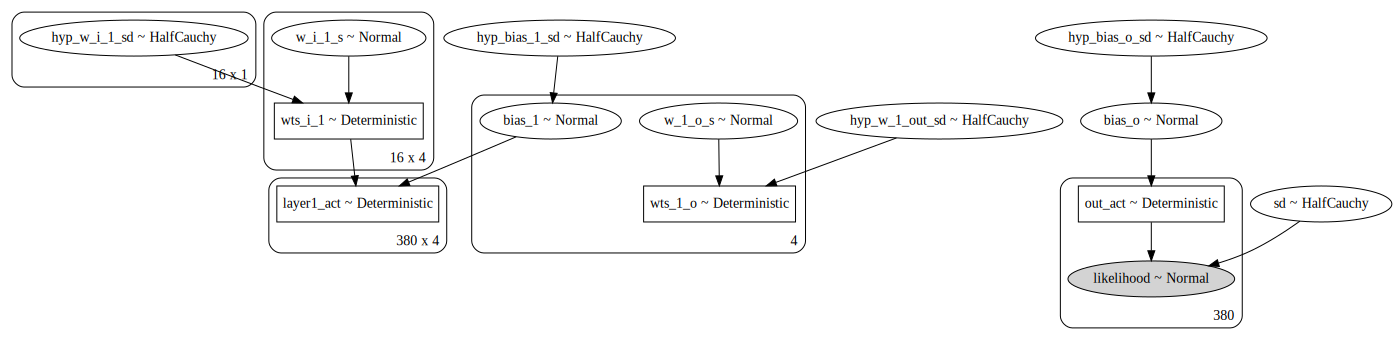

In [19]:
X_shared = shared(X_s_train.values)
bnn_l1_4HL_CHL = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train, n_hidden=4,)
bnn_l1_4HL_CHL.show_model()

In [20]:
bnn_l1_4HL_CHL.fit(n_samples=2000, tune=2500, chains=1 )# nuts_kwargs=dict(target_accept=0.9,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, bias_o, bias_1, w_1_o_s, w_i_1_s, hyp_bias_o_sd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
100%|██████████| 4500/4500 [06:37<00:00, 11.33it/s]
There were 339 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7116001221561474, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [22]:
bnn_l1_4HL_CHL.trace_.get_sampler_stats('depth').max()

9

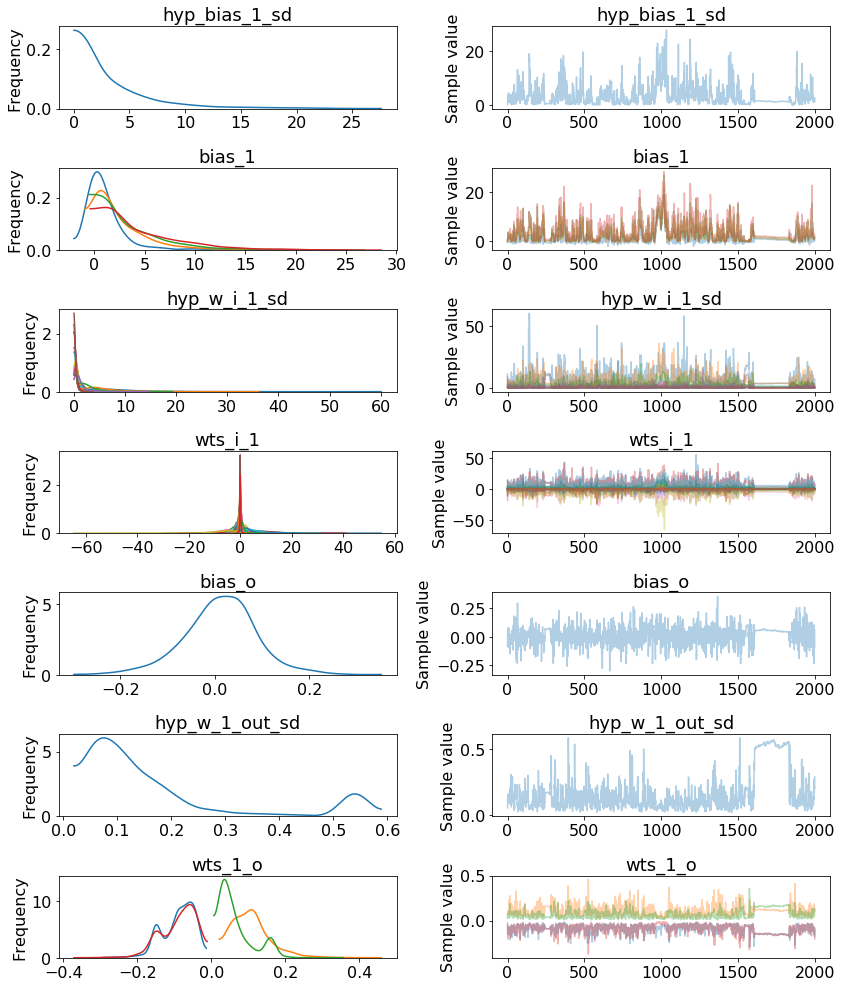

In [24]:
bnn_l1_4HL_CHL.evaluate_fit(['hyp_bias_1_sd', 'bias_1', 'hyp_w_i_1_sd','wts_i_1', 'bias_o', 'hyp_w_1_out_sd', 'wts_1_o']);

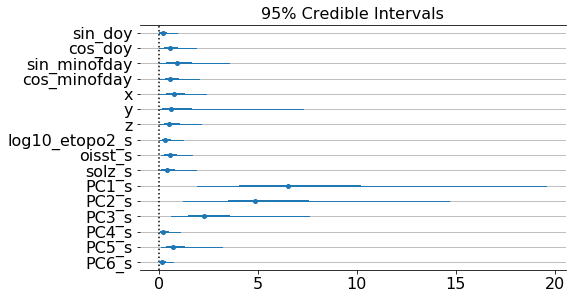

In [26]:
labels = ['%s' %li for li in lbls_X_s ]
bnn_l1_4HL_CHL.show_forest(['hyp_w_i_1_sd'], feat_labels=labels)
f = pl.gcf()
f.set_figwidth(8);
#a = pl.gca()
#a.set_xscale('log')

In [75]:
axf.get_xlim()

(-20.0, 23.49912471779184)

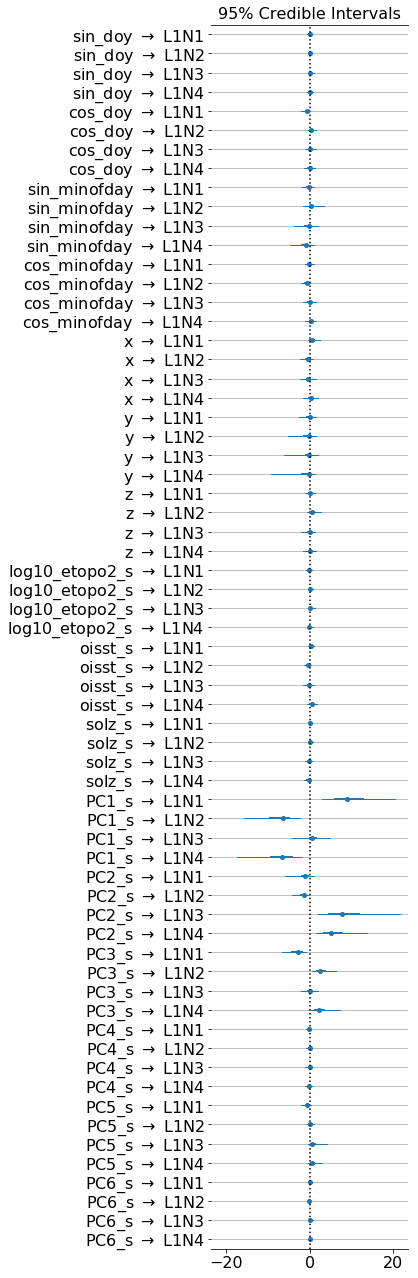

In [78]:
labels = [r'%s $\rightarrow$ L1N%d' %(li, ni) for li in lbls_X_s for ni in range(1, 5)]
bnn_l1_4HL_CHL.show_forest(['wts_i_1'], feat_labels=labels)
f = pl.gcf()
f.set_figheight(20);
f.tight_layout(w_pad=0.5)
axf=pl.gca();
axf.set_xticks([-20, 0, 20]);
axf.set_xlim(left=-23.5, right=23.5)
f.savefig('./figJar/bnn_l1_4HL_chl_wts_i_1_interp.pdf', dpi=300, format='pdf')

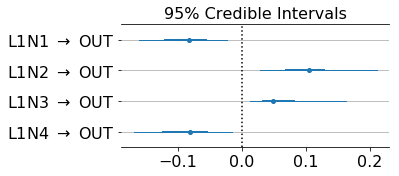

In [29]:
labels = [r'L1N%d $\rightarrow$ OUT' %ni for ni in range(1, 5)]
bnn_l1_4HL_CHL.show_forest(['wts_1_o'], feat_labels=labels)
f = pl.gcf()
f.set_figheight(2);

100%|██████████| 2000/2000 [00:02<00:00, 745.82it/s]


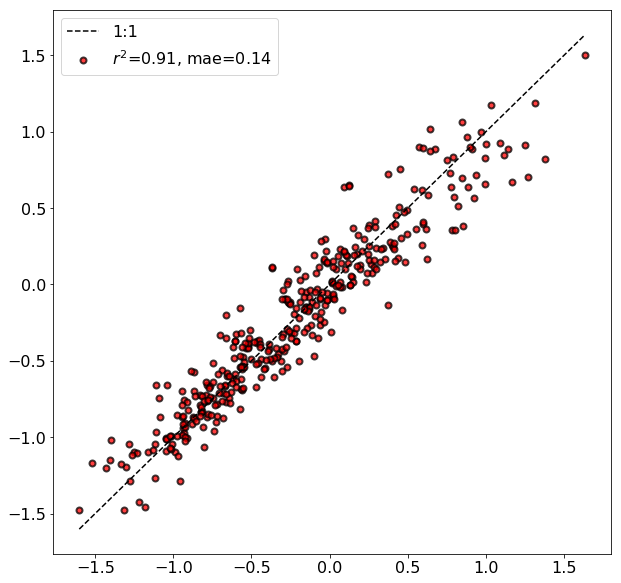

In [40]:
# Check fit on training model
X_shared.set_value(X_s_train.values)
ppc_train_l1_CHL = bnn_l1_4HL_CHL.predict(likelihood_name='likelihood')
ax_train_ = plot_obs_against_ppc(y_train, ppc_train_l1_CHL, plot_1_to_1=True,
                                 color='red', alpha=0.75, linewidth=2)

100%|██████████| 2000/2000 [00:02<00:00, 723.52it/s]


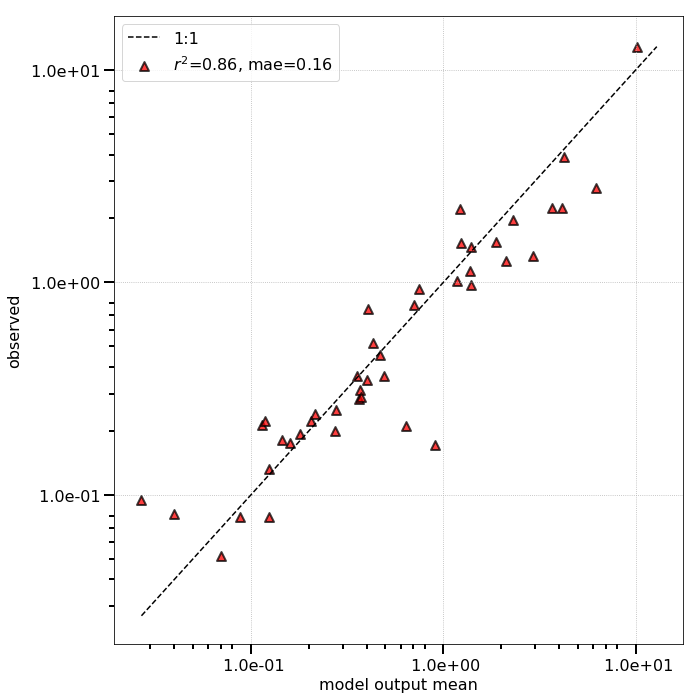

In [79]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_CHL = bnn_l1_4HL_CHL.predict(likelihood_name='likelihood')
ax_test = plot_obs_against_ppc(y_test, ppc_test_CHL, plot_1_to_1=True, s=80,
                              color='red', alpha=0.75, linewidth=2, marker='^')
ax_test.set_yticks(np.log10(np.asarray([1e-1, 1e-0, 1e1])))
ax_test.set_xticks(np.log10(np.asarray([1e-1, 1e-0, 1e1])))
minor_ticks = np.concatenate((np.arange(3e-2, 9e-2, 1e-2), np.arange(2e-1, 9e-1, 1e-1),
                             np.arange(2e0, 9e0, 1e0)))
ax_test.set_yticks(np.log10(minor_ticks), minor=True)
ax_test.set_xticks(np.log10(minor_ticks), minor=True)
ax_test.tick_params(axis='both', which='minor', length=5, width=2)
ax_test.tick_params(axis='both', which='major', length=10, width=2)
#ax_test.tick_params(axis='x', which='both', length=0, width=0)
ax_test.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_test.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_test.grid(ls=':')
ax_test.set_xlabel('model output mean')
ax_test.set_ylabel('observed')
f = pl.gcf()
f.tight_layout()
f.savefig('./figJar/OO_2018/chl_test.pdf', dpi=300, format='pdf')

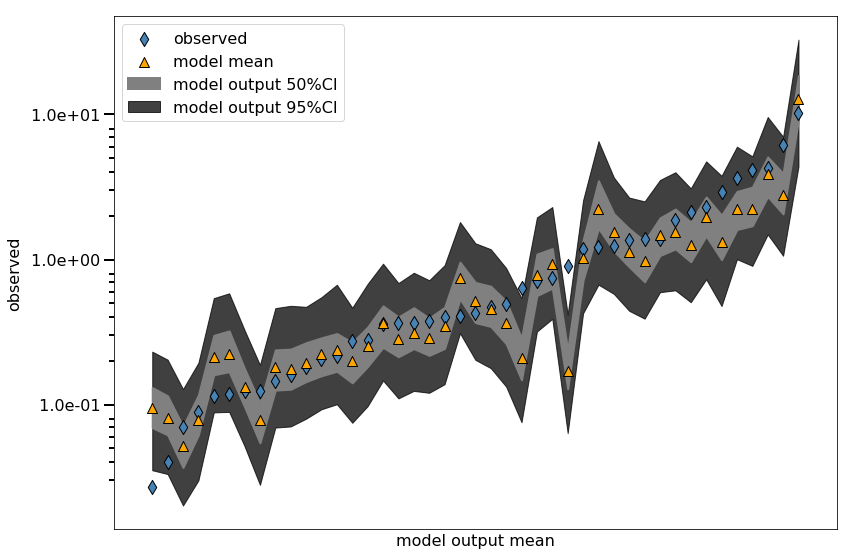

In [83]:
ax_unc = plot_fits_w_estimates(y_test, ppc_test_CHL)
ax_unc.set_yticks(np.log10(np.asarray([1e-1, 1e-0, 1e1])))
minor_ticks = np.concatenate((np.arange(3e-2, 9e-2, 1e-2), np.arange(2e-1, 9e-1, 1e-1),
                             np.arange(2e0, 9e0, 1e0)))
ax_unc.set_yticks(np.log10(minor_ticks), minor=True)
ax_unc.tick_params(axis='y', which='minor', length=5, width=2)
ax_unc.tick_params(axis='y', which='major', length=10, width=2)
ax_unc.tick_params(axis='x', which='both', length=0, width=0)
ax_unc.set_xticks([])
ax_unc.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_unc.grid(ls=':')
ax_unc.set_xlabel('model output mean')
ax_unc.set_ylabel('observed')
f = pl.gcf()
f.tight_layout()
f.savefig('./figJar/OO_2018/bnn_l1_hl_4_chl_unc.pdf')

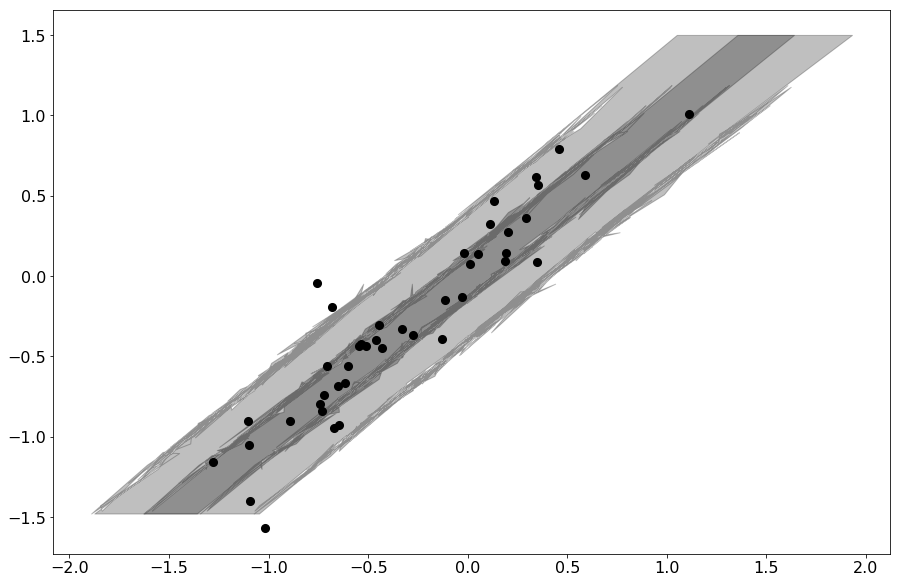

In [43]:
f, ax = pl.subplots(figsize=(15, 10))
f.subplots_adjust(wspace=0, hspace=0.1)

uncertainty_plot_2(ppc_train_l1_CHL, ppc_test_CHL, y_test, y_train,
                  ax=ax, band_color='k')

In [44]:
pickledModelDict = {
                    bnn_l1_4HL_CHL.model.name: bnn_l1_4HL_CHL,
                   }
with open('./pickleJar/Models/CHL_BNN_4_HL1_ARD.pkl', 'wb') as f:
    pickle.dump(pickledModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)